# 1.创建模型
为了适应一些手写数字的模型，对模型的一些参数进行了修改
原版的请参考mobilenet_v2.py

In [55]:
from torch import nn
import torch


def _make_divisible(ch, divisor=8, min_ch=None):
    """
    这个函数取自原始的tf回购。
   它确保所有层都有一个能被8整除的通道号
   从这里可以看到:
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8

    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_ch is None:
        min_ch = divisor
    new_ch = max(min_ch, int(ch + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_ch < 0.9 * ch:
        new_ch += divisor
    return new_ch


class ConvBNReLU(nn.Sequential):
    """
    V2中使用的卷积结构
    """

    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, groups=1):
        """

        如果group设置成 in_channel的维数,这样子的卷积操作就变成了dw操作
        """
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_channel,
                      out_channel,
                      (kernel_size, kernel_size),
                      (stride, stride),
                      padding,
                      groups=groups,
                      bias=False),
            # 因为我们要使用bn层，所有这里的偏置不起任何作用
            nn.BatchNorm2d(out_channel),
            nn.ReLU6(inplace=True)
        )


class InvertedResidual(nn.Module):
    """
    定义倒残差结构
    """

    def __init__(self, in_channel, out_channel, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        # 隐藏层通道数=输入通道*扩展因子,
        # 其实就是1*1卷积核的个数
        hidden_channel = in_channel * expand_ratio
        # 是否使用短连接，
        # 当stride为1，且输入特这鞥矩阵与输出特征矩阵的shape相同时才有shortcut链接
        self.use_shortcut = stride == 1 and in_channel == out_channel

        layers = []
        # 如果扩展因子不等于1的话
        if expand_ratio != 1:
            # 1x1 pointwise conv
            # 就会有1*1的卷积层
            layers.append(ConvBNReLU(in_channel, hidden_channel, kernel_size=1))
        layers.extend([
            # 3x3 depthwise conv
            ConvBNReLU(hidden_channel, hidden_channel, stride=stride, groups=hidden_channel),
            # 1x1 pointwise conv(linear)
            nn.Conv2d(hidden_channel, out_channel, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(out_channel),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_shortcut:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, alpha=1.0, round_nearest=8):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = _make_divisible(32 * alpha, round_nearest)
        last_channel = _make_divisible(64 * alpha, round_nearest)
        print("last_channel", last_channel)
        print("input_channel", input_channel)
        inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            # [6, 96, 3, 1],
            # [6, 160, 3, 2],
            # [6, 320, 1, 1],
        ]

        features = []
        # conv1 layer，这个是第一个卷积,需要的是3通道,这里我修改称1通道，因为是黑白图片
        features.append(ConvBNReLU(1, input_channel, stride=2))

        # 开始构建以下的部分
        # building inverted residual residual blockes
        for t, c, n, s in inverted_residual_setting:
            # 构建倒残差结构
            output_channel = _make_divisible(c * alpha, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        # building last several layers，定义表格中的卷积层
        features.append(ConvBNReLU(input_channel, last_channel, 1))

        # 到这里特征已经全部提取完毕
        # combine feature layers
        self.features = nn.Sequential(*features)

        # building classifier，定义下次样
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes)
        )

        # weight initialization
        # 初始化权重的的意思
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = MobileNetV2(num_classes=10)

last_channel 64
input_channel 32


In [56]:
import torch
from torch.utils import data  # 获取迭代数据
from torch.autograd import Variable  # 获取变量
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import mnist  # 获取数据集
import matplotlib.pyplot as plt
from torch import nn
import os

path = r"./model"
if not os.path.exists(path):
    os.mkdir(path)


def get_dataloader(mode):
    """
    获取数据集加载
    :param mode:
    :return:
    """
    #准备数据迭代器
    # 这里我已经下载好了，所以是否需要下载写的是false
    #准备数据集，其中0.1307，0.3081为MNIST数据的均值和标准差，这样操作能够对其进行标准化
    #因为MNIST只有一个通道（黑白图片）,所以元组中只有一个值
    dataset = torchvision.datasets.MNIST('../../data/mini', train=mode,
                                         download=False,
                                         transform=torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(
                                                 (0.1307,), (0.3081,))
                                         ]))

    return DataLoader(dataset, batch_size=64, shuffle=True)

In [57]:


# 加载预训练模型
# model_weight_path = "./mobilenet_v2.pth"
# assert os.path.exists(model_weight_path), "file {} dose not exist.".format(model_weight_path)
# # 载入权重字典
# pre_weights = torch.load(model_weight_path, map_location='cpu')
# # 删除classifier weights
# pre_dict = {k: v for k, v in pre_weights.items() if model.state_dict()[k].numel() == v.numel()}
#
# # 冻结特征提取部分的权重
# for param in model.features.parameters():
#     param.requires_grad = False

loss_func = nn.CrossEntropyLoss()

params = [p for p in model.parameters() if p.requires_grad]
opt = torch.optim.Adam(model.parameters(), lr=0.001)
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

In [58]:
import numpy as np


def train(epoch):
    loss_count = []
    # 获取训练集
    train_loader = get_dataloader(True)
    print("训练集的长度", len(train_loader))
    for i, (x, y) in enumerate(train_loader):
        # 通道数是1 ,28*28的灰度图,batch_size=64
        batch_x = Variable(x)  # torch.Size([batch_size, 1, 28, 28])
        batch_y = Variable(y)  # torch.Size([batch_size])
        # 获取最后输出
        out = model(batch_x)  # torch.Size([batch_size,10])
        # 获取损失
        loss = loss_func(out, batch_y)
        # 使用优化器优化损失
        opt.zero_grad()  # 清空上一步残余更新参数值
        loss.backward()  # 误差反向传播，计算参数更新值
        opt.step()  # 将参数更新值施加到net的parmeters上
        if i % 200 == 0:
            loss_count.append(loss.item())
            print('训练次数{}---{}:\t--损失值{}'.format(
                epoch,
                i, loss.item()))
            # 保存训练模型，以便下次使用

            torch.save(model.state_dict(), r'./model/cnn_model.pkl')
    # 打印测试诗句
    # print(loss_count)
    plt.figure('PyTorch_CNN_的损失值')
    plt.plot(range(len(loss_count)), loss_count, label='Loss')
    plt.title('PyTorch_CNN_的损失值')
    plt.legend()
    plt.show()


训练集的长度 938
训练次数0---0:	--损失值2.298621654510498
训练次数0---200:	--损失值0.2675950825214386
训练次数0---400:	--损失值0.03968646749854088
训练次数0---600:	--损失值0.07387620210647583
训练次数0---800:	--损失值0.04365703463554382


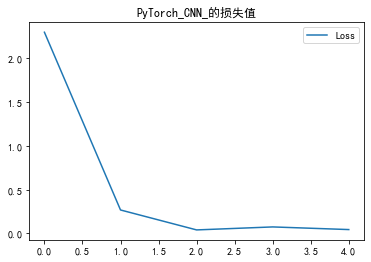

测试了100批次准确率为:	 1.0
测试了100批次准确率为:	 0.96875
总准确率：	 0.9761146496815286
[1.0, 0.953125, 0.984375, 0.984375, 0.984375, 1.0, 0.953125, 0.921875, 0.96875, 0.96875, 0.96875, 0.984375, 0.984375, 0.90625, 1.0, 0.9375, 0.984375, 0.96875, 0.96875, 0.953125, 0.984375, 0.953125, 0.953125, 0.96875, 0.96875, 1.0, 1.0, 0.984375, 0.953125, 1.0, 1.0, 0.984375, 0.984375, 0.96875, 1.0, 1.0, 0.96875, 0.921875, 0.96875, 1.0, 0.921875, 0.984375, 0.953125, 0.96875, 1.0, 1.0, 0.984375, 0.9375, 0.984375, 1.0, 0.984375, 0.953125, 0.96875, 0.9375, 1.0, 0.9375, 0.9375, 0.984375, 1.0, 0.984375, 0.984375, 0.96875, 0.96875, 0.96875, 0.984375, 0.96875, 0.96875, 0.953125, 0.984375, 0.96875, 0.984375, 0.96875, 1.0, 1.0, 0.984375, 0.984375, 0.96875, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 0.90625, 0.984375, 0.984375, 0.953125, 1.0, 0.96875, 1.0, 0.984375, 0.984375, 1.0, 0.96875, 0.953125, 1.0, 0.984375, 1.0, 1.0, 0.96875, 1.0, 0.96875, 0.984375, 0.984375, 0.984375, 0.984375, 0.984375, 0.984375, 0.96875, 1.0, 1.0, 0.9

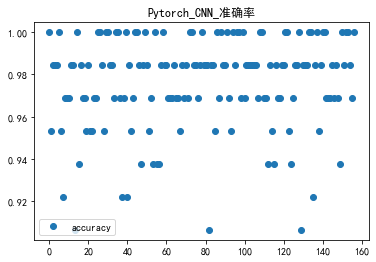

训练集的长度 938
训练次数1---0:	--损失值0.06611811369657516
训练次数1---200:	--损失值0.01006704568862915
训练次数1---400:	--损失值0.03845612332224846
训练次数1---600:	--损失值0.05810136720538139
训练次数1---800:	--损失值0.06189412623643875


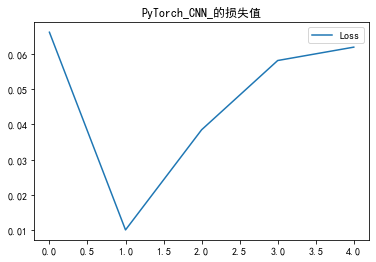

测试了100批次准确率为:	 1.0
测试了100批次准确率为:	 0.96875
总准确率：	 0.9842754777070064
[1.0, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 0.96875, 0.984375, 1.0, 0.984375, 0.96875, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 0.96875, 0.953125, 0.984375, 0.984375, 0.984375, 0.984375, 1.0, 0.984375, 0.984375, 0.96875, 0.96875, 0.984375, 0.96875, 1.0, 0.984375, 1.0, 0.953125, 1.0, 0.9375, 0.96875, 1.0, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 0.96875, 0.96875, 1.0, 0.984375, 0.96875, 1.0, 0.96875, 0.984375, 1.0, 0.9375, 0.96875, 0.96875, 1.0, 0.984375, 0.984375, 0.984375, 0.96875, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.96875, 0.984375, 1.0, 1.0, 0.96875, 0.984375, 0.953125, 1.0, 0.96875, 1.0, 0.96875, 0.984375, 0.984375, 0.984375, 1.0, 1.0, 0.96875, 0.953125, 0.984375, 0.953125, 1.0, 0.96875, 0.984375, 1.0, 0.984375, 0.984375, 0.984375, 1.0, 0.96875, 0.953125, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 0.96875, 0.98437

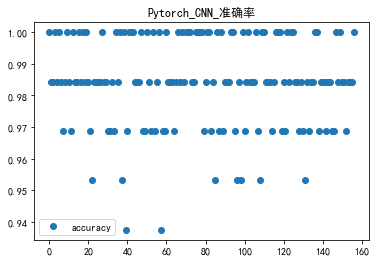

训练集的长度 938
训练次数2---0:	--损失值0.10599659383296967
训练次数2---200:	--损失值0.02281034365296364
训练次数2---400:	--损失值0.06575636565685272
训练次数2---600:	--损失值0.01577090471982956
训练次数2---800:	--损失值0.01995464786887169


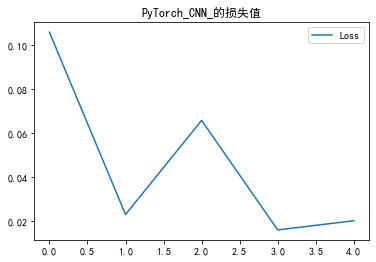

测试了100批次准确率为:	 0.984375
测试了100批次准确率为:	 0.953125
总准确率：	 0.9844745222929936
[0.984375, 0.984375, 0.953125, 0.96875, 0.984375, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 0.953125, 1.0, 0.9375, 1.0, 1.0, 0.96875, 0.96875, 0.96875, 0.984375, 0.9375, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.984375, 1.0, 0.96875, 0.984375, 1.0, 0.9375, 1.0, 0.984375, 0.96875, 1.0, 0.984375, 1.0, 1.0, 0.953125, 0.984375, 0.984375, 1.0, 0.953125, 0.984375, 1.0, 0.96875, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 0.96875, 0.984375, 0.96875, 0.984375, 1.0, 0.96875, 1.0, 0.984375, 0.984375, 0.96875, 1.0, 0.984375, 1.0, 0.953125, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 0.953125, 0.984375, 0.984375, 0.96875, 1.0, 0.9375, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.984375, 1.0, 0.953125, 0.953125, 0.984375, 1.0, 1.0, 1.0, 0.984375, 0.984375, 0.984375, 0.984375, 0.96875, 1.0, 0.96875, 0.96875, 0.984375, 0.984375, 1.0, 1.0, 1.0, 0.984375, 

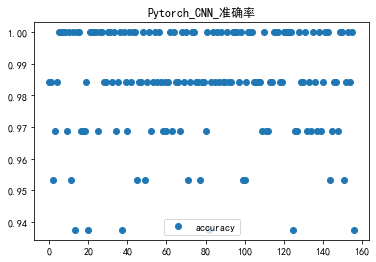

In [59]:
def test():
    # 获取测试集
    accuracy_sum = []
    test_loader = get_dataloader(False)
    for index, (a, b) in enumerate(test_loader):
        test_x = Variable(a)
        test_y = Variable(b)
        out = model(test_x)
        accuracy = torch.max(out, 1)[1].numpy() == test_y.numpy()
        accuracy_sum.append(accuracy.mean())
        if index % 100 == 0:
            print('测试了100批次准确率为:\t', accuracy.mean())

    print('总准确率：\t', sum(accuracy_sum) / len(accuracy_sum))
    # 精确率图
    # print('总准确率：\t', sum(accuracy_sum) / len(accuracy_sum))
    plt.figure('Accuracy')
    print(accuracy_sum)
    plt.plot(range(len(accuracy_sum)), accuracy_sum, 'o', label='accuracy')
    plt.title('Pytorch_CNN_准确率')
    plt.legend()
    plt.show()


# 先训练一次
# train(0)
#
# test_loader = get_dataloader(False)
#
# for index, (a, b) in enumerate(test_loader):
#     test_x = Variable(a)
#     test_y = Variable(b)
#     show_image(test_x)
#     out = model(test_x)
#     print(out)
#     print(torch.max(out, 1)[1].numpy())
#     break
# 进行测试和训练
for epoch in range(3):
    train(epoch)
    test()